In [1]:
from glob import glob
from datetime import datetime
from scipy.stats import ttest_ind
from sklearn.preprocessing import MaxAbsScaler,StandardScaler

import random
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from datetime import datetime , timedelta
import time
import copy
import tensorflow as tf

In [2]:
def get_datasets(all_dataset):
    train_val = all_dataset[all_dataset.index<=int(len(all_dataset)/len(all_dataset['station_id'].unique()))*0.80]
    test = all_dataset[all_dataset.index>int(len(all_dataset)/len(all_dataset['station_id'].unique()))*0.80]
    train = train_val[train_val.index<=int(len(train_val)/len(train_val['station_id'].unique()))*0.80]
    val = train_val[train_val.index>int(len(train_val)/len(train_val['station_id'].unique()))*0.80]

    return train,val,test

def print_up_to_2_accuracy(lstm_,col1,col2):
    print((lstm_[col1]==lstm_[col2]).sum()/len(lstm_))
    print((lstm_[col1]+1==lstm_[col2]).sum()/len(lstm_))
    print((lstm_[col1]-1==lstm_[col2]).sum()/len(lstm_))
    print((lstm_[col1]+2==lstm_[col2]).sum()/len(lstm_))
    print((lstm_[col1]-2==lstm_[col2]).sum()/len(lstm_))

def buildManyToOneModel(model_name,shape):
    model = Sequential()
    if model_name=='LSTM':
        model.add(LSTM(32, input_shape=(shape[1],shape[2]),return_sequences=True))
        model.add(LSTM(16, input_shape=(shape[1],shape[2]),return_sequences=False))
        # model.add(LSTM(32, input_shape=(shape[1],shape[2]),return_sequences=False))
    if model_name=='GRU':
        model.add(GRU(32, input_shape=(shape[1],shape[2]),return_sequences=True))
        model.add(GRU(16, input_shape=(shape[1],shape[2]),return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu' ))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001,
        name="Adam"
        ), metrics=['accuracy', 'mse']
    )
    model.summary()
    return model

def build_training_data(sample_data, all_data, used_days,which):
    if which=='test':
        col4='actual_inbound_minus_outbound_copy'
        col2='actual_inbound_minus_outbound'
    else:
        col4='actual_inbound_minus_outbound'
        col2='actual_inbound_minus_outbound_copy'
    x_train = []   
    y_train = []   
    Pasthours = 24 * used_days
    Futurehours = 1
    # unique_h = sample_data['hour'].unique()
    unique_h_all = all_data['hour2'].unique()
    hours=[]
    stati=[]
    means=[]
    for kk in range(len(sample_data.index)):
        if kk%100000==0:
            print(kk)
        i=sample_data.index[kk]
        # print(i)
        if i[0]<unique_h_all[-1]-Pasthours-Futurehours:
            ind = all_data.index.get_loc(i)
            source_df = all_data.iloc[ind:ind+Pasthours][[j for j in all_data.columns if j not in ['hour','hour2','station_id','from_actual value','to_actual value','from_actual value_copy','to_actual value_copy',col4]]]
            s_ = source_df[col2].to_list()
            # print(len(s_))
            mean_x= np.array([s_[l] for l in [p*24 for p in range(7)]]).mean() 
            means.append(mean_x)
            # print(source_df.columns)
            x_train.append(np.array(source_df))
            df_target = all_data.iloc[ind+Pasthours:ind+Pasthours+Futurehours][[col2]]
            # print(df_target.columns)
            hours.append(df_target.index[0][0])
            stati.append(df_target.index[0][1])
            if which!='test':
                y_train.append(np.array(df_target[col2].to_list()-mean_x))
            else:
                y_train.append(np.array(df_target[col2].to_list()))
    # x_train, y_train = np.asarray(x_train), np.asarray(y_train) 
    return np.array(x_train), np.array(y_train),hours,stati,means

def get_df_final(hou,stati,predictions1,Y_val_inverse):
    predictions1 = pd.DataFrame(predictions1).rename(columns={0:'predicted value'})
    Y_val_inverse = pd.DataFrame(Y_val_inverse).rename(columns={0:'actual value'})
    
    final = pd.concat([predictions1,Y_val_inverse],axis=1)
    final['rounded_predicted_inbound_minus_outbound']=np.round(final['predicted value'])
    final.loc[:, 'rounded_predicted_inbound_minus_outbound'] = final['rounded_predicted_inbound_minus_outbound'].replace(-0, 0)
    final['rounded_actual value']=np.round(final['actual value'])
    final.loc[:, 'rounded_actual value'] = final['rounded_actual value'].replace(-0, 0)
    final['hour']=hou
    final['station_id']=stati
    print_up_to_2_accuracy(final,'rounded_predicted_inbound_minus_outbound','rounded_actual value')
    return final

class kv_pair(dict): 
    def __init__(self): 
        self = dict() 
    def add(self, key, value): 
        self[key] = value 

In [ ]:
Rent_df=pd.read_csv('RentTop_whole.csv')
Return_df=pd.read_csv('ReturnTop_whole.csv')

In [ ]:
num_=100
df=Rent_df.copy()
station_counts_from =pd.DataFrame(df["start_station_id"].value_counts()).sort_index(ascending=True)
station_counts_from.rename(columns={'count':'checkins'}, inplace=True)

station_counts_to= pd.DataFrame(df["end_station_id"].value_counts()).sort_index(ascending=True)
station_counts_to.rename(columns={'count':'checkouts'}, inplace=True)
station_counts = pd.concat([station_counts_from, station_counts_to], axis=1)

station_counts['total'] = station_counts['checkouts'] + station_counts['checkins']

station_counts_20 = station_counts.sort_values('total', ascending=False).head(num_).iloc[0:100]


In [ ]:
Rent_df2 = Rent_df[Rent_df['start_station_id'].isin(list(station_counts_20.index))]
Return_df2 = Return_df[Return_df['end_station_id'].isin(list(station_counts_20.index))]


In [ ]:
# start_st = Rent_df2.copy()
# gb_column = 'start_station_id'
# time_column = 'started_at'

start_st = Return_df.copy()
gb_column = 'end_station_id'
time_column = 'ended_at'



station_count =pd.DataFrame(start_st.groupby([gb_column])['hour'].count())
station_count.sort_values(by=['hour'], inplace=True, ascending=False)
station_rank = list(station_count.index)
start_st.set_index(time_column, inplace = True)
start_st['groupby_col'] = start_st.index.map(lambda x:str(x)[:13])
start_st_model =pd.DataFrame(start_st.groupby([gb_column, 'groupby_col'])['hour'].count())
start_st_model.rename(columns={'hour':'from_cnt'}, inplace=True)
start_st_model.reset_index(inplace=True)
start_st_model.index = start_st_model['groupby_col']
all_time = []
start_time = datetime.strptime("2018-01-01 00:00:00" , "%Y-%m-%d %H:%M:%S")    
end_time = datetime.strptime("2021-12-31 23:00:00" , "%Y-%m-%d %H:%M:%S")    
current_date = start_time.date()
while current_date <= end_time.date() :
    i = 0
    for i in range (0,24) :
        current_data_str = current_date.strftime("%Y-%m-%d") 
        all_time.append("%s"%str(current_data_str)+" %i:00:00"%(i))
        i = i+1 
    current_date = current_date + timedelta(days=1)
all_time = pd.DataFrame(all_time)
# print(all_time)  # 2018-01-01 0:00:00 until 2021-12-31 23:00:00 aka 35064 hours
all_time.columns = ["Time"] # set it's column name as Time
all_time['Time'] = pd.to_datetime(all_time['Time'])  #convert it to datetime

all_data_=pd.DataFrame(columns=['station_id'])
for station in station_rank:
    fliter = (start_st_model[gb_column] == station)
    picked_station_data = start_st_model[fliter]

    picked_station_data['groupby_col'] = pd.to_datetime(picked_station_data['groupby_col'])
    picked_station_data.drop(gb_column, axis=1, inplace=True)
    picked_station_data = picked_station_data.rename(columns={"groupby_col":"Time"})
    picked_station_data['Time'] = pd.to_datetime(picked_station_data['Time'])
    picked_station_data = pd.merge(all_time, picked_station_data,on=['Time'],how='left')
    picked_station_data = picked_station_data.fillna(0)
    picked_station_data.index = picked_station_data['Time']
    picked_station_data['year'] = picked_station_data.index.map(lambda x:str(x)[:4])  
    picked_station_data['month'] = picked_station_data.index.map(lambda x:str(x)[5:7])
    picked_station_data['hour'] = picked_station_data.index.map(lambda x:str(x)[11:13])
    picked_station_data['day'] = picked_station_data.index.day_name()
    picked_station_data.drop('Time', axis=1, inplace=True)
    picked_station_data.reset_index(inplace=True)
    picked_station_data = picked_station_data.drop(['Time', 'year'],axis=1)
    ## 'Start station', 'year', 'month', 'day', 'hour' columns to be converted to dummies
    picked_station_data = pd.get_dummies(data=picked_station_data, columns=['month', 'day', 'hour'])  
    # scaler = MaxAbsScaler()
    # picked_station_data['from_cnt'] = scaler.fit_transform(picked_station_data['from_cnt'].values.reshape(-1,1))
    for i in picked_station_data.columns:
        picked_station_data[i] = picked_station_data[i].astype('float')     
    picked_station_data['station_id']=station
    all_data_=pd.concat([all_data_,picked_station_data])
    
# all_data_.to_csv('Return_data_all_data_.csv',index=False)  

def index_and_sort(all_data_):
    
    for i in all_data_.columns:
        all_data_[i] = all_data_[i].astype('float') 
    all_data_.index=[i for i in range(int(len(all_data_)/len(all_data_['station_id'].unique())))]*len(all_data_['station_id'].unique())
    all_data_ = all_data_.reset_index().sort_values(['station_id','index'],ascending=True).set_index('index')
    return all_data_

Return_data=pd.read_csv('Return_data'+'_all_data_.csv') 
Rent_data=pd.read_csv('Rent_data'+'_all_data_.csv') 
Return_data=index_and_sort(Return_data)
Rent_data=index_and_sort(Rent_data)

Rent_data['to'+'_actual value']=Return_data.rename(columns={'from_cnt':'to'+'_actual value'})[['to'+'_actual value']]['to'+'_actual value'].to_list()
Rent_data=Rent_data.rename(columns={'from_cnt':'from'+'_actual value'})
Rent_data['actual_inbound_minus_outbound']=Rent_data['to'+'_actual value']-Rent_data['from'+'_actual value']
# Rent_data.to_csv('df_'+'Rent_and_Return'+'.csv',index=False)

In [3]:
all_dataset = Rent_data.copy()
all_dataset.index=[i for i in range(int(len(all_dataset)/len(all_dataset['station_id'].unique())))]*len(all_dataset['station_id'].unique())

In [4]:
all_dataset2=all_dataset.copy()
all_dataset2['actual_inbound_minus_outbound_copy']=all_dataset2['actual_inbound_minus_outbound'].copy()
all_dataset2['to_actual value_copy']=all_dataset2['to_actual value'].copy()
all_dataset2['from_actual value_copy']=all_dataset2['from_actual value'].copy()
all_dataset2=all_dataset2.reset_index()
all_dataset2=all_dataset2.rename(columns={'index':'hour'}) 
all_dataset2.index=[i for i in range(int(len(all_dataset2)/len(all_dataset2['station_id'].unique())))]*len(all_dataset2['station_id'].unique())
all_dataset2['hour2']=all_dataset2['hour'].copy()

In [5]:
train_lstm,val_lstm,test_lstm = get_datasets(all_dataset2)


In [6]:
num_batches=27
# num_batches = int(len(train_lstm['hour'].unique())/(7*24*5))
for batch_index in range(num_batches):
    batch_threshold = 7*24*5
    if batch_index==num_batches-1:
        train_lstm[train_lstm['hour2']>=batch_index*batch_threshold].to_csv('Scaled_data_batch_'+str(batch_index)+'_train_data.csv',index=False)
    else:
        train_lstm[(train_lstm['hour2']>=batch_index*batch_threshold)&(train_lstm['hour2']<(batch_index+1)*batch_threshold)].to_csv('Scaled_data_batch_'+str(batch_index)+'_train_data.csv',index=False)

In [7]:

all_dataset2 = all_dataset2.set_index(['hour', 'station_id'])
val_lstm = val_lstm.set_index(['hour', 'station_id'])
test_lstm = test_lstm.set_index(['hour', 'station_id'])


In [8]:
max_possible_random_hour_val = val_lstm['hour2'].max()-(7*24)-1

unique_hours = val_lstm['hour2'].unique()
random_hours = np.random.choice(unique_hours[unique_hours <= max_possible_random_hour_val], size=int(len(val_lstm['hour2'].unique())*0.1), replace=False)
sample_val_lstm=val_lstm[val_lstm['hour2'].isin(random_hours)]
print(len(val_lstm))
print(len(sample_val_lstm))
print(len(val_lstm[val_lstm['hour2']<=max_possible_random_hour_val]))
sample_test_lstm = test_lstm[test_lstm['hour2']<=test_lstm['hour2'].unique()[0]+ int(len(test_lstm['hour2'].unique())*0.1)]
print(len(test_lstm))
print(len(sample_test_lstm))
x_val, y_val,_,_,_= build_training_data(sample_val_lstm, val_lstm,  7,'val')
x_test, y_test,hou,stati,means = build_training_data(sample_test_lstm,test_lstm, 7,'test')


561000
56100
544100
701200
70200
0
0


In [9]:
preds=[]
sample_data_mean = pd.DataFrame({'hour': hou, 'station_id': stati}).set_index(['hour','station_id'])
for kk in range(len(sample_data_mean.index)):
    i=sample_data_mean.index[kk]
    ind = all_dataset2.index.get_loc(i)
    preds.append(all_dataset2.iloc[[ind-(j*24) for j in range(1,8)]]['actual_inbound_minus_outbound_copy'].mean())  


In [14]:
model_name='GRU'
all_history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
for i in range(num_batches):
    sample_train_lstm = pd.read_csv('Scaled_data_batch_'+str(i)+'_train_data.csv')
    sample_train_lstm = sample_train_lstm.set_index(['hour', 'station_id'])
    np.random.seed(i)
    unique_hours = sample_train_lstm['hour2'].unique()
    max_possible_random_hour_train = sample_train_lstm['hour2'].max()-(7*24)-1
    random_hours = np.random.choice(unique_hours[unique_hours <= max_possible_random_hour_train], size=int(len(sample_train_lstm['hour2'].unique())*0.1), replace=False)
    sample_train_lstm2=sample_train_lstm[sample_train_lstm['hour2'].isin(random_hours)]
    x_train, y_train,_,_,_ = build_training_data(sample_train_lstm2,sample_train_lstm, 7,'train')
    if i==0:
        model = buildManyToOneModel(model_name,x_train.shape)
        callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")

    history = model.fit(x_train, y_train, epochs=2, batch_size=128, validation_data=(x_val, y_val), callbacks=[callback])

    all_history['loss'].extend(history.history['loss'])
    all_history['accuracy'].extend(history.history['accuracy'])
    all_history['val_loss'].extend(history.history['val_loss'])
    all_history['val_accuracy'].extend(history.history['val_accuracy'])
    

0
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 168, 32)           7488      
                                                                 
 gru_1 (GRU)                 (None, 16)                2400      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 10177 (39.75 KB)
Trainable params: 10177 (39.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
66/66 

In [15]:
#GRU
if model_name =='GRU':
    predictions2 = model.predict(x_test)
    predictions2 = np.array(means) + predictions2.reshape(-1)
    Y_val_inverse=y_test.copy()
    final_gru = get_df_final(hou,stati,predictions2,Y_val_inverse)



2194/2194 [==============================] - 33s 14ms/step
0.4987891737891738
0.14652421652421652
0.1543162393162393
0.055997150997150996
0.05817663817663818


In [13]:
#LSTM 
if model_name =='LSTM':
    predictions1 = model.predict(x_test)
    predictions1 = np.array(means) + predictions1.reshape(-1)
    Y_val_inverse=y_test.copy()
    final_lstm = get_df_final(hou,stati,predictions1,Y_val_inverse)
    


2194/2194 [==============================] - 39s 18ms/step
0.49961538461538463
0.14341880341880342
0.15673789173789174
0.05465811965811966
0.059002849002849


In [1]:
# #Mean
# final_mean = get_df_final(hou,stati,preds,y_test.copy())

In [17]:
# dict_models={'LSTM':final_lstm,'GRU':final_gru,'Mean':final_mean}
dict_models={'LSTM':final_lstm,'GRU':final_gru}

In [18]:
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_squared_log_error, median_absolute_error,r2_score,explained_variance_score
from sklearn.metrics import max_error, median_absolute_error, mean_absolute_percentage_error
def get_df_measures(model, final):
    whole_df=final.copy()
    whole_df['model']=model
    
    dict_ref={'rounded_predicted_inbound_minus_outbound':'rounded_actual value'}
    df_metrics1=pd.DataFrame()
    for i in whole_df['model'].unique():
        for j in whole_df[whole_df['model']==i]['station_id'].unique():
            
            for k in ['rounded_predicted_inbound_minus_outbound']:
                temp_df = whole_df[(whole_df['model']==i)&(whole_df['station_id']==j)]
                predicted = temp_df[k].to_list()
                
                actual = temp_df[dict_ref[k]].to_list()
                one_ = mean_squared_error(actual, predicted)
                two_ = mean_absolute_error(actual, predicted)
                four_ = median_absolute_error(actual, predicted)
                five_ = r2_score(actual, predicted)
                six_ = explained_variance_score(actual, predicted)
                seven_ = max_error(actual, predicted)
                eight_ = max_error(actual, predicted)
                nine=mean_squared_error(actual, predicted,squared=False)
                df_m=pd.DataFrame([[i,j,k,one_,two_,four_,five_,six_,seven_,eight_,nine]],columns=['Model','station_id','to_or_from','MSE','MAE','MedianAE','R2','Explained Variance','Max Error','MAPE','RMSE'])
                df_metrics1=pd.concat([df_metrics1,df_m])

    return df_metrics1

In [19]:
dict_measures=kv_pair()
for model_ in dict_models:
    dict_measures.add(model_,get_df_measures(model_,dict_models[model_]))

In [20]:
for k in dict_measures:
    dict_measures[k].to_csv('measures1_'+k+'.csv',index=False)
for k in dict_models:
    dict_models[k].to_csv('predictions1_'+k+'.csv',index=False)
        

Text(0, 0.5, 'Value')

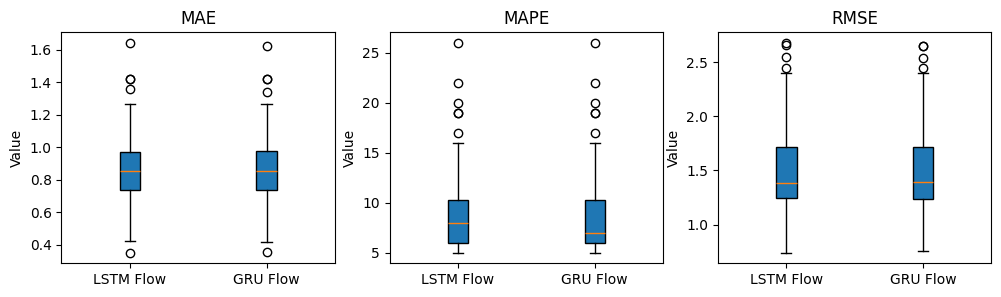

In [22]:
# Setting up the matplotlib figure
plt.figure(figsize=(12, 3))

# Creating boxplot for MAE
plt.subplot(1, 3, 1)
what='MAE'

plt.boxplot([dict_measures[model_][dict_measures[model_]['to_or_from']=='rounded_predicted_inbound_minus_outbound'][what].to_list() for model_ in dict_measures]
             , vert=True, patch_artist=True)

plt.title(what)
plt.xticks(range(1, len(dict_models)+1), [i + ' Flow' for i in dict_models])
plt.ylabel('Value')


plt.subplot(1, 3, 2)
what='MAPE'
plt.boxplot([dict_measures[model_][dict_measures[model_]['to_or_from']=='rounded_predicted_inbound_minus_outbound'][what].to_list() for model_ in dict_measures]
             , vert=True, patch_artist=True)


plt.title(what)
plt.xticks(range(1, len(dict_models)+1), [i + ' Flow' for i in dict_models])
plt.ylabel('Value')


plt.subplot(1, 3, 3)
what='RMSE'
plt.boxplot([dict_measures[model_][dict_measures[model_]['to_or_from']=='rounded_predicted_inbound_minus_outbound'][what].to_list() for model_ in dict_measures]
             , vert=True, patch_artist=True)

plt.title(what)
plt.xticks(range(1, len(dict_models)+1), [i + ' Flow' for i in dict_models])
plt.ylabel('Value')
# plt.savefig('metrics_LSTM_GRU.png',dpi=300)

In [ ]:
test_2 = dict_models['LSTM']
test_2['model']='LSTM'
test_2 = dict_models['GRU']
test_3['model']='GRU'
whole_df = pd.concat([test_2,test_3])

In [ ]:
min_hour = whole_df['hour'].min()
whole_df['hour']=whole_df['hour'].apply(lambda x: x- min_hour+1)
whole_df=whole_df.rename(columns={'actual value':'actual_inbound_minus_outbound'})
whole_df=whole_df[['model','hour','station_id','actual_inbound_minus_outbound','rounded_predicted_inbound_minus_outbound']]
whole_df['station_id']=whole_df['station_id'].astype('str')

In [ ]:
loc = pd.read_csv('Toronto_station_data.csv')
loc['station_id']=loc['station_id'].astype('str')
loc=loc[loc['station_id'].isin(whole_df['station_id'].unique())]
whole_df = pd.merge(whole_df,loc[['station_id','name']],on='station_id',how='outer')
_ = whole_df.groupby(['station_id']).count().reset_index()[['station_id']]
_['station_index']=[i+1 for i in range(len(_))]
whole_df=pd.merge(whole_df,_,on=['station_id'],how='outer')
loc=pd.merge(loc,_,on=['station_id'],how='outer')
# whole_df[['model','hour','station_index','station_id','name','actual_inbound_minus_outbound','rounded_predicted_inbound_minus_outbound']].to_csv('Par_station_needs1.csv',index=False)
# loc[['station_index','station_id','name','lat','lon','capacity']].to_csv('Par_station_capacity1.csv',index=False)